In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
from glob import glob# data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from collections import Counter
import os



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-05-14 23:55:36.491057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747266936.738039      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747266936.809064      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
Path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"

In [5]:
def class_distribution(path):
    normal = len(os.listdir(os.path.join(path, "NORMAL")))
    pneumonia = len(os.listdir(os.path.join(path, "PNEUMONIA")))
    return {"NORMAL": normal, "PNEUMONIA": pneumonia}

print("Train:", class_distribution(Path + "/train"))
print("Val:  ", class_distribution(Path + "/val"))
print("Test: ", class_distribution(Path + "/test"))

Train: {'NORMAL': 1342, 'PNEUMONIA': 3876}
Val:   {'NORMAL': 9, 'PNEUMONIA': 9}
Test:  {'NORMAL': 234, 'PNEUMONIA': 390}


# 1. Prétraitement des images

In [6]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation + rescaling for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# No augmentation for validation/test
val_test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 8
img_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    Path + "/train",
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    Path + "/val",
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    Path + "/test",
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# 2. Modèle CNN simple

In [7]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Input(shape=(224, 224, 1)),

    Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

2025-05-14 23:56:06.036872: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# 3. Compilation du modèle

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])





# 4. Entraînement du modèle

In [9]:
early_stop = EarlyStopping(
    monitor='val_loss',           # Surveille la perte validation
    patience=5,                   # Attend 2 epochs sans amélioration
    restore_best_weights=True     # Recharge les meilleurs poids
)

In [10]:
tf.keras.backend.clear_session(
    free_memory=True
)

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


652/652 ━━━━━━━━━━━━━━━━━━━━ 242s 360ms/step - accuracy: 0.8387 - loss: 0.8501 - val_accuracy: 0.5000 - val_loss: 2.7140
Epoch 2/20
652/652 ━━━━━━━━━━━━━━━━━━━━ 237s 362ms/step - accuracy: 0.9130 - loss: 0.5113 - val_accuracy: 0.7500 - val_loss: 0.6072
Epoch 3/20
652/652 ━━━━━━━━━━━━━━━━━━━━ 237s 363ms/step - accuracy: 0.9134 - loss: 0.4689 - val_accuracy: 0.6250 - val_loss: 0.9355
Epoch 4/20
652/652 ━━━━━━━━━━━━━━━━━━━━ 241s 368ms/step - accuracy: 0.9092 - loss: 0.4727 - val_accuracy: 1.0000 - val_loss: 0.5093
Epoch 5/20
652/652 ━━━━━━━━━━━━━━━━━━━━ 236s 361ms/step - accuracy: 0.9233 - loss: 0.4323 - val_accuracy: 0.7500 - val_loss: 0.9088
Epoch 6/20
652/652 ━━━━━━━━━━━━━━━━━━━━ 261s 359ms/step - accuracy: 0.9350 - loss: 0.3889 - val_accuracy: 0.8125 - val_loss: 0.8099
Epoch 7/20
652/652 ━━━━━━━━━━━━━━━━━━━━ 234s 358ms/step - accuracy: 0.9273 - loss: 0.3840 - val_accuracy: 0.8750 - val_loss: 0.4941
Epoch 8/20
652/652 ━━━━━━━━━━━━━━━━━━━━ 234s 358ms/step - accuracy: 0.9371 - loss: 0.35

# 5. Évaluation sur validation

In [12]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"\nValidation Accuracy: {val_acc:.2%} | Loss: {val_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8750 - loss: 0.5019

Validation Accuracy: 87.50% | Loss: 0.4941


# 6. Évaluation sur test

In [14]:
import os
print("NORMAL:", len(os.listdir(Path+"/test/NORMAL")))
print("PNEUMONIA:", len(os.listdir(Path+"/test/PNEUMONIA")))

NORMAL: 234
PNEUMONIA: 390


In [13]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.2%} | Loss: {test_loss:.4f}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.8528 - loss: 0.6384

Test Accuracy: 88.94% | Loss: 0.5030


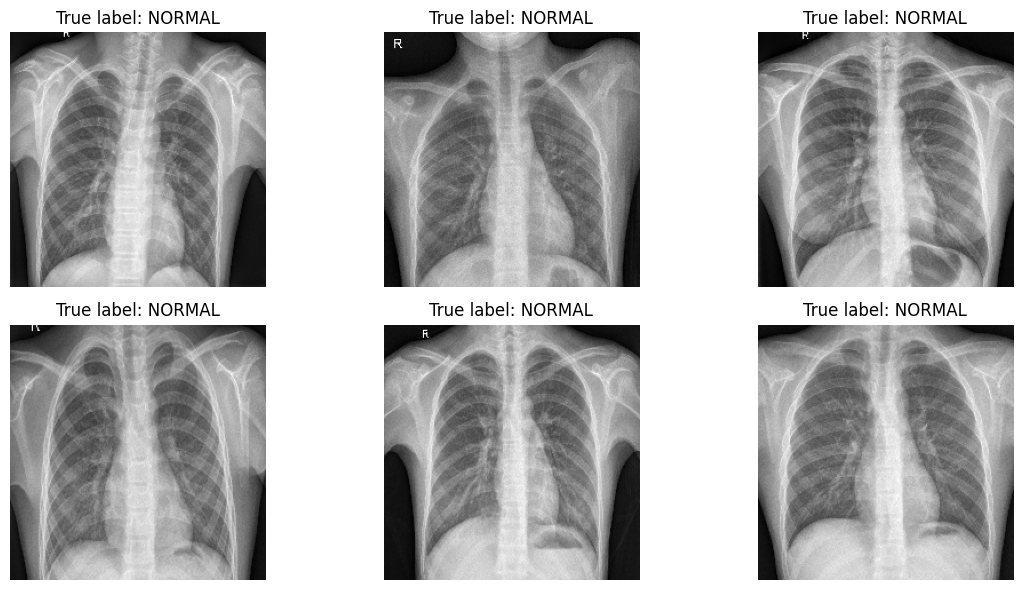

In [20]:
import matplotlib.pyplot as plt

# On prend les premières images du générateur
images, labels = next(test_generator)
# Afficher 9 images aléatoires
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    label = 'PNEUMONIA' if labels[i] == 1 else 'NORMAL'
    plt.title(f"True label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# 7. Model Accuracy vs Model Loss

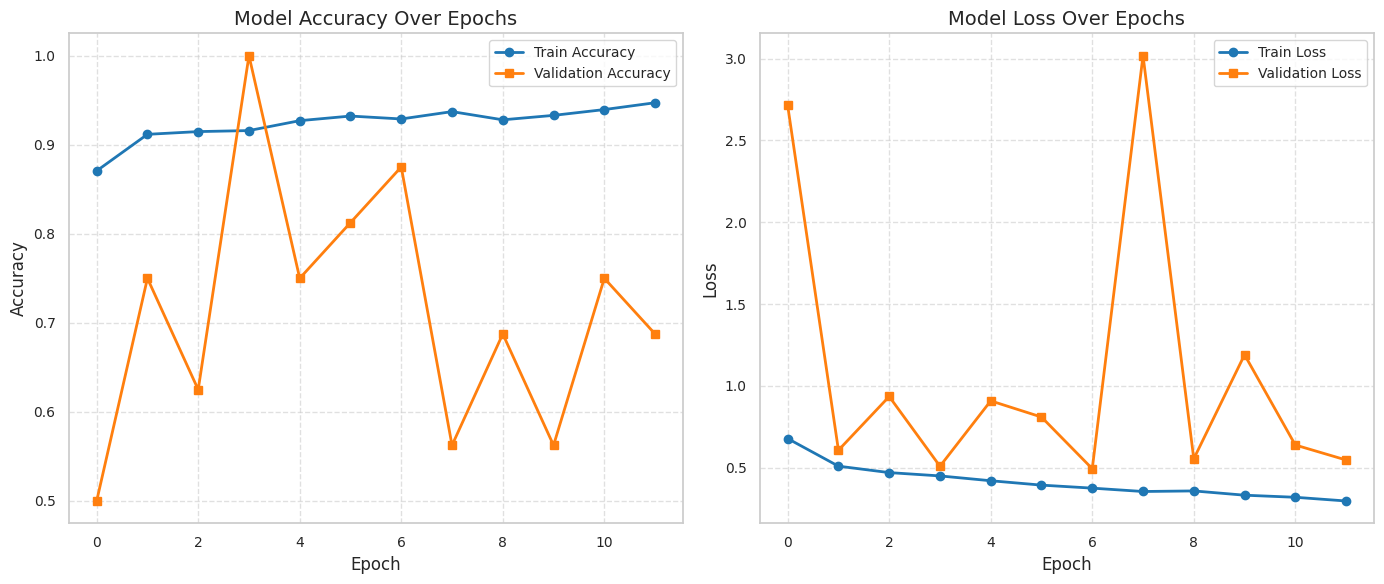

In [22]:
import seaborn as sns
sns.set(style="whitegrid")

# Define colors and styles
train_color = '#1f77b4'   # Blue
val_color = '#ff7f0e'     # Orange

plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color=train_color, linewidth=2, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color=val_color, linewidth=2, marker='s')
plt.title('Model Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color=train_color, linewidth=2, marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color=val_color, linewidth=2, marker='s')
plt.title('Model Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


# 8. Confusion Matrix 

78/78 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step


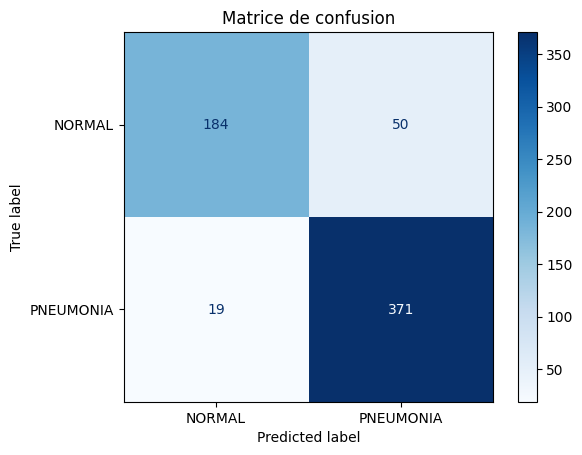

In [18]:
# Prédictions sur tout le set test
test_generator.reset()
pred_probs = model.predict(test_generator)
pred_labels = (pred_probs > 0.5).astype(int).flatten()
true_labels = test_generator.classes

# Matrice de confusion
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap='Blues')
plt.title("Matrice de confusion")
plt.show()


In [ ]:
model.save("CNN_Model.h5")  # Format HDF5